In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
from itertools import combinations
from statsmodels.stats.multitest import multipletests
import sys

main_dir = ''
func_dir = main_dir + 'utils/'
fig_dir = main_dir + 'results/paper_figures/'

sys.path.insert(0,func_dir)

import mouse_data_functions as cs
from fig_4_functions import make_mouse_df_stimulus_comparisons, fig4_violinplot,add_stars_2_sets,add_violin_custom_colors,plot_neuronal_properties_comparison,make_monkey_df_stimulus_comparisons
from fig_4_functions import add_violin_custom_colors_3, add_anova_stars_2_sets, store_control_alphas_mouse, get_control_evars
from neuron_properties_functions import create_empty_monkey_stats_dict, get_SNR_monkey_all_dates, get_split_half_r_monkey_all_dates, get_max_corr_vals_monkey_all_dates
from neuron_properties_functions import create_empty_mouse_stats_dict, get_split_half_r_all_mice, get_SNR_all_mice, get_max_corr_vals_all_mice
from macaque_data_functions import get_resps, get_get_condition_type




## Mouse dataset type comparisons

In [4]:
## store the lengths of the neurons and frames

mouse_stats= create_empty_mouse_stats_dict(main_dir)
get_SNR_all_mice(main_dir, mouse_stats)
get_split_half_r_all_mice(main_dir, mouse_stats)
get_max_corr_vals_all_mice(main_dir, mouse_stats)

seed = 17
dataset_types = ['ori32','natimg32']
area='L23'
area2='L4'
activity_type = 'resp'
L23_lengths = []
L4_lengths = []
trial_lengths = []
for dataset_type in dataset_types:
    mt = cs.mt_retriever(main_dir, dataset_type=dataset_type)
    mousenames= sorted(mt.filenames)
    for mouse in mousenames:
        resp_L1, resp_L23, resp_L2, resp_L3, resp_L4 = mt.retrieve_layer_activity(activity_type, mouse)
        L23_lengths.append(len(mouse_stats[dataset_type][mouse]['L23']['SNR_meanspont']))
        L4_lengths.append(len(mouse_stats[dataset_type][mouse]['L4']['SNR_meanspont']))
        trial_lengths.append(resp_L23.shape[0])

L23_control_lengths = L23_lengths[np.argsort(np.array(L23_lengths))[1]]
L4_control_lengths = L4_lengths[np.argsort(np.array(L4_lengths))[1]]
control_trial_length = np.min(trial_lengths)

In [ ]:
store_control_alphas_mouse(mouse_stats, 'ori32', 'MP031', input_control_lengths=L4_control_lengths,pred_control_lengths=L23_control_lengths,
                        sample_size=500, frames_to_reduce=5, n_splits=10)

In [ ]:
get_control_evars(mouse_stats,input_control_lengths=L4_control_lengths,pred_control_lengths= L23_control_lengths,
                  control_trial_length=control_trial_length,animal='mouse', area=area,area2=area2,dataset_types=dataset_types,
                  num_seeds=10, shuffle_frames=False, seed=20)

get_control_evars(mouse_stats,input_control_lengths=L4_control_lengths,pred_control_lengths= L23_control_lengths,
                  control_trial_length=control_trial_length,animal='mouse', area=area,area2=area2,dataset_types=dataset_types,
                  num_seeds=10, shuffle_frames=True, seed=20)

### plotting

In [71]:
df_mouse_all = make_mouse_df_stimulus_comparisons(mouse_stats)
dfmouse = df_mouse_all[df_mouse_all.control_shuffle==False].reset_index()

variable1='Direction'
variable2='Dataset Type'
filt_df_mouse = dfmouse[(dfmouse.SNR>2)&(dfmouse['Split-half r']>0.8)]
filt_df_mouse = filt_df_mouse[filt_df_mouse['Mouse_Name'].isin(['MP031','MP032','MP033'])].reset_index()
filt_df_mouse_null = df_mouse_all[(df_mouse_all.SNR>2)&(df_mouse_all['Split-half r']>0.8)&(df_mouse_all.control_shuffle==True)]
filt_df_mouse_null = filt_df_mouse_null[filt_df_mouse_null['Mouse_Name'].isin(['MP031','MP032','MP033'])].reset_index()
dataset_types = ['ori32', 'natimg32']
directions= ['L4→L2/3', 'L2/3→L4']
palette= ['#D3D3D3','#404040']

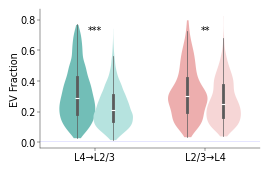

In [72]:
neuron_property='EV'
fig, ax = plt.subplots(figsize=((2.85,1.8)))
fontsize=7
fig4_violinplot(filt_df_mouse, x=variable1, y=neuron_property, 
                hue=variable2, ax=ax,
                label_order=directions, hue_order=dataset_types,
                gap=-0.1,width=0.65,cut=0,
                linewidth=0, saturation=1, palette=['#72BEB7','#EDAEAE']
                )

ax.legend_.remove()
ax.tick_params(axis='both', labelsize=fontsize, width=0.3, length=2, pad=1)
add_violin_custom_colors(ax)
sns.despine()
ax.spines[:].set_linewidth(0.3)
ax.set_ylabel('EV Fraction', fontsize=fontsize, labelpad=0)

add_stars_2_sets(filt_df_mouse, neuron_property, x=variable1, x_order=directions,
                 hue=variable2, ax=ax, height1=0.85, height2=0.85, perm_type='ind', hierarchical=True)

data = filt_df_mouse_null['EV']
per_25 = np.percentile(data.dropna().values, 25)
per_75 = np.percentile(data.dropna().values, 75)
ax.axhspan(per_25, per_75, alpha=0.1, color='blue', label='shuffle\ncontrol IQR',
        linewidth=0,
           )
plt.show()

### supplemental

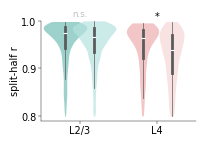

In [14]:
import matplotlib.pyplot as plt
variable1='Area'
variable2='Dataset Type'
dataset_types = ['ori32', 'natimg32']
directions= ['L2/3','L4']
figsize=(2,1.3)

mouse_args = {'height1':1.05, 'height2':1.05}

neuron_property='Split-half r'
fig, ax = plt.subplots(figsize=figsize)
plot_neuronal_properties_comparison(filt_df_mouse, variable1, neuron_property, variable2, 
                                        ax, fontsize=7, label_order=directions, hue_order=dataset_types, 
                                        yticks=[0.8,0.9,1], ylabel='split-half r', animal='mouse', stats_args=mouse_args)
# Get the y-axis ticks
y_ticks = plt.gca().get_yticks()
# Check if 1 is among the ticks
if 1 in y_ticks:
    ax.set_ylim(top=1)
    
plt.show()

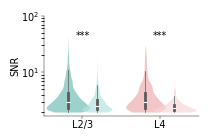

In [39]:
neuron_property='SNR'
fig, ax = plt.subplots(figsize=figsize)
plot_neuronal_properties_comparison(filt_df_mouse, variable1, neuron_property, variable2, 
                                        ax, fontsize=7, label_order=directions, hue_order=dataset_types,
                                        ylabel=None, log_scale=True, stats_args={'height1':0.8, 'height2':0.8})
ax.set_ylim(top=100)
plt.show()

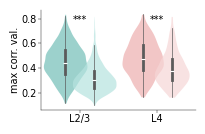

In [40]:
neuron_property='max corr. val'
fig, ax = plt.subplots(figsize=figsize)
plot_neuronal_properties_comparison(filt_df_mouse, variable1, neuron_property, variable2, 
                                        ax, fontsize=7, label_order=directions, hue_order=dataset_types, 
                                        yticks=None, ylabel='max corr. val.', animal='mouse',stats_args={'height1':0.9, 'height2':0.9})
plt.show()

## Monkey dataset type comparisons

### coding

In [73]:
all_ini_stim_offs = {'SNR': 400, 'SNR_spont': 200, 'RS': None,
                    'RS_open':None, 'RS_closed': None, 
                    'RF_thin':1000, 'RF_large':1000, 'RF_thin_spont':200, 'RF_large_spont':200}

monkey_stats= create_empty_monkey_stats_dict()
get_SNR_monkey_all_dates(monkey_stats)
get_split_half_r_monkey_all_dates(monkey_stats)
get_max_corr_vals_monkey_all_dates(monkey_stats)


V4_lengths = []
V1_lengths = []
area='V4'
area2='V1'
dataset_types = ['SNR', 'RF_thin', 'RF_large']
w_size=25
for dataset_type in dataset_types:
    for date in monkey_stats[dataset_type]:
        V4_lengths.append(len(monkey_stats[dataset_type][date][area]['SNR_meanspont']))
        V1_lengths.append(len(monkey_stats[dataset_type][date][area2]['SNR_meanspont']))
        resp_V4, resp_V1= get_resps(condition_type=get_get_condition_type(dataset_type), date=date, w_size=w_size, stim_on=0, stim_off=all_ini_stim_offs[dataset_type])
        trial_lengths.append(resp_V4.shape[0])

V4_control_lengths = V4_lengths[np.argsort(np.array(V4_lengths))[1]] #control for number of neurons?
V1_control_lengths = V1_lengths[np.argsort(np.array(V1_lengths))[1]]
control_trial_length = np.min(trial_lengths)

In [74]:
get_control_evars(monkey_stats,input_control_lengths=V1_control_lengths,pred_control_lengths= V4_control_lengths,
                control_trial_length=control_trial_length,animal='monkey', area=area,area2=area2,dataset_types=dataset_types,
                num_seeds=10, shuffle_frames=False, seed=20)

yay! it took 1.36 minutes to finish all dataset types!


In [75]:

get_control_evars(monkey_stats,input_control_lengths=V1_control_lengths,pred_control_lengths= V4_control_lengths,
                control_trial_length=control_trial_length,animal='monkey', area=area,area2=area2,dataset_types=dataset_types,
                num_seeds=10, shuffle_frames=True, seed=20)


yay! it took 1.35 minutes to finish all dataset types!


### plotting

In [3]:
df_monkey_all = make_monkey_df_stimulus_comparisons(monkey_stats)
filt_df_monkey = df_monkey_all[(df_monkey_all.control_shuffle==False)&(df_monkey_all['Split-half r']>0.8)&(df_monkey_all.SNR>=2)].reset_index(drop=True)
filt_df_monkey_null= df_monkey_all[(df_monkey_all.control_shuffle==True)&(df_monkey_all['Split-half r']>0.8)&(df_monkey_all.SNR>=2)].reset_index(drop=True)
dataset_types=['RF_thin', 'RF_large', 'SNR']
variable1='Direction'
variable2='Dataset Type'
directions = ['V1→V4','V4→V1']
figsize=(3,2)


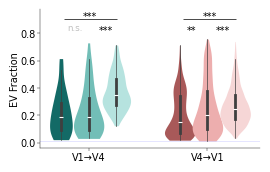

In [4]:
neuron_property='EV'
fig, ax = plt.subplots(figsize=((2.85,1.8)))
fontsize=7
fig4_violinplot(filt_df_monkey, x=variable1, y=neuron_property, 
                hue=variable2, ax=ax, label_order=directions, 
                hue_order=dataset_types, gap=-0.1,width=0.7,cut=0,
                linewidth=0, saturation=1, palette=['lightseagreen','lightcoral','#72BEB7']
                )
ax.legend_.remove()
sns.despine()
ax.set_ylabel('EV Fraction', fontsize=fontsize, labelpad=0)
ax.tick_params(axis='both', labelsize=fontsize, width=0.3, length=2, pad=1)
sns.despine()
ax.spines[:].set_linewidth(0.3)
add_violin_custom_colors_3(ax)
add_anova_stars_2_sets(filt_df_monkey, neuron_property, x=variable1, x_order=directions,
                       hue=variable2, hue_order=dataset_types, ax=ax, fontsize=fontsize,height1=0.85, height2=0.95, height3=0.85,
                       stars1_positions=[0.16,0.23,0.30],
                       stars2_positions=[0.69,0.77,0.83])
data = filt_df_monkey_null['EV']
per_25 = np.percentile(data.dropna().values, 25)
per_75 = np.percentile(data.dropna().values, 75)
ax.axhspan(per_25, per_75, alpha=0.1, color='blue', label='shuffle\ncontrol IQR',
        linewidth=0,
           )
# Get the y-axis ticks
y_ticks = plt.gca().get_yticks()
# Check if 1 is among the ticks
if 1 in y_ticks:
    ax.set_ylim(top=1)
# plt.show()



### supplemental

In [5]:
variable1='Area'
variable2='Dataset Type'
dataset_types = ['RF_thin', 'RF_large', 'SNR']
directions= ['V4','V1']
figsize=(2,1.3)


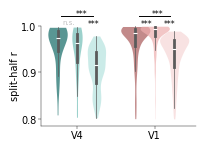

In [6]:
stats_args = {'fontsize': fontsize*0.8, 'height1':1.02, 'height2': 1.12, 'height3': 1.02, 'stars1_positions': [0.18,0.26,0.34],'stars2_positions':[0.68,0.75,0.83],'bar_height':0.02 }
neuron_property='Split-half r'

fig, ax = plt.subplots(figsize=figsize)
plot_neuronal_properties_comparison(filt_df_monkey, variable1, neuron_property, variable2, 
                                        ax, fontsize=7, label_order=directions, hue_order=dataset_types, 
                                        yticks=[0.8,0.9,1], ylabel='split-half r', animal='monkey', stats_args=stats_args)
# Get the y-axis ticks
y_ticks = plt.gca().get_yticks()
# Check if 1 is among the ticks
if 1 in y_ticks:
        ax.set_ylim(top=1)
ax.plot([-0.2,0.2], # -0.095, units are width of the axes
        [1.101, 1.101], # 0 to 500, units are same as the y-axis
        clip_on=False,
        transform=ax.get_xaxis_transform(),
        color='black', linewidth=0.7)
ax.plot([0.804,1.2], # -0.095, units are width of the axes
        [1.101, 1.101], # 0 to 500, units are same as the y-axis
        clip_on=False,
        transform=ax.get_xaxis_transform(),
        color='black', linewidth=0.7)
plt.show()

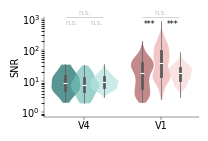

In [9]:
stats_args = {'fontsize': fontsize*0.8, 'height1':0.92, 'height2': 1.02, 'height3': 0.92, 
              'stars1_positions': [0.18,0.26,0.34],'stars2_positions':[0.68,0.75,0.83],'bar_height':0.02 }
neuron_property='SNR'
fig, ax = plt.subplots(figsize=figsize)
plot_neuronal_properties_comparison(filt_df_monkey, variable1, neuron_property, variable2, 
                                        ax, fontsize=7, label_order=directions, hue_order=dataset_types, 
                                        yticks=None, ylabel=None, animal='monkey', stats_args=stats_args,
                                        log_scale=True)
# ax.set_ylim(top=100)
plt.show()

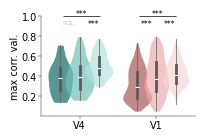

In [8]:
stats_args = {'fontsize': fontsize*0.8, 'height1':0.92, 'height2': 1.02, 'height3': 0.92,'stars1_positions': [0.18,0.26,0.34],'stars2_positions':[0.68,0.75,0.83],'bar_height':0.02 }
neuron_property='max corr. val'

fig, ax = plt.subplots(figsize=figsize)
plot_neuronal_properties_comparison(filt_df_monkey, variable1, neuron_property, variable2, 
                                        ax, fontsize=7, label_order=directions, hue_order=dataset_types, 
                                        yticks=None, ylabel='max corr. val.', animal='monkey', stats_args=stats_args)
# Get the y-axis ticks
y_ticks = plt.gca().get_yticks()
# Check if 1 is among the ticks
if 1 in y_ticks:
    ax.set_ylim(top=1)
plt.show()